In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 스마트팜 배출량에 대한 예측
- smart_farm_final.csv

## Feature Engineering
- Q. 시간 데이터를 효과적으로 모델에 포함시킬 수 있는 방법이 없나?
- A. hour,minute을 합해서 float으로 변환하기, sin_time, cos_time을 추가하기
- Q. 온도와 습도가 결국 스마트팜에 있어서 중요한 요인이기에 파생변수를 추가하기
- A. 온도와 습도를 통해서 만들 수 있는 이슬점 데이터를 추가하기
- Q. 일출시간, 일몰시간을 기반으로 zenith(태양의 고도) 계산하기
- A. 태양의 고도가 곧, 일사량과 태양 복사 에너지에 주된, 요인이기에 핵심적인 요인으로 이용될 수도 있음

In [4]:
#data = pd.read_csv("smart_farm_final.csv")
org_data = pd.read_csv("smart_farm_final.csv")
org_data.shape

(148168, 57)

- 이슬점 데이터 생성하기

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import glob
import os
import seaborn as sns
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import warnings
warnings.filterwarnings("ignore")

In [10]:
org_data["팬코일 B동"].value_counts()

1.0    93920
0.0    54246
0.5        2
Name: 팬코일 B동, dtype: int64

In [5]:
c = 243.12
b = 17.62
gamma = (b * (org_data['내부 온도']) / (c + (org_data['내부 온도']))) + np.log(org_data['내부 습도'] / 100)
dp = ( c * gamma) / (b - gamma)
org_data['이슬점'] = dp

- merge hour and minute feature into 1

In [6]:
org_data["hour_float"] = org_data.시 + org_data.분/60

- add cyclical encoded time feature
- continueous time feature

In [7]:
org_data['cos_time'] = np.cos(2*np.pi*(org_data.hour_float/24))
org_data['sin_time'] = np.sin(2*np.pi*(org_data.hour_float/24))

일출 일몰 시간에 따른 년간, 일별 계절성(seasonality)를 고려한 일별 2차 함수 근사를 통해 zenith angle 산출
- zenith angle (태양의 고도)

In [8]:
import numpy as np
import os

import random
import math
from scipy.optimize import curve_fit

In [9]:
def obj_curve(x, a, b, c):
    return a*(x-b)**2+c

일출, 일몰시간 데이터 다루기
- float 형태로 변환해주기

In [8]:
import gc

gc.collect()

75

#### 시,분 string 을 float으로 변경하는 함수 : hour_str_to_float

In [9]:
def hour_str_to_float(x):
    hour = int(str(x)[:-2])
    minute = int(str(x)[-2:])
    
    return hour + minute/60

In [10]:
sunrise_data = org_data[["시간","일출시간","일몰시간","hour_float"]].copy()

sunrise_data["일출시간_float"] = sunrise_data["일출시간"].apply(lambda x : hour_str_to_float(x))
sunrise_data["일몰시간_float"] = sunrise_data["일몰시간"].apply(lambda x : hour_str_to_float(x))

In [11]:
sunrise_data.head(3)

,시간,일출시간,일몰시간,hour_float,일출시간_float,일몰시간_float
0,2021-11-26 00:00:00,713,1717,0.000000,7.216667,17.283333
1,2021-11-26 00:01:00,713,1717,0.016667,7.216667,17.283333
2,2021-11-26 00:02:00,713,1717,0.033333,7.216667,17.283333


In [12]:
zenith_lst = np.load("zenith.npy")

In [13]:
sunrise_data["zenith"] = zenith_lst

- altutude of sun is added

In [14]:
sunrise_data['altitude'] = 90-sunrise_data.zenith

In [15]:
sunrise_data.head(3)

,시간,일출시간,일몰시간,hour_float,일출시간_float,일몰시간_float,zenith,altitude
0,2021-11-26 00:00:00,713,1717,0.000000,7.216667,17.283333,231.228926,-141.228926
1,2021-11-26 00:01:00,713,1717,0.016667,7.216667,17.283333,230.739259,-140.739259
2,2021-11-26 00:02:00,713,1717,0.033333,7.216667,17.283333,230.250259,-140.250259


In [16]:
data = pd.merge(org_data.drop(["일출시간","일몰시간"],axis=1),
                sunrise_data[["일출시간_float","일몰시간_float","zenith","altitude","시간"]],
                on="시간", how = "inner")

시간 데이터 처리하기
- 연도 : numerical
- 월 : non numerical
- 일 : non numerical
- 시 : non numerical
- 분 : non numerical

In [17]:
data = data.drop(["년월일","일","분"],axis=1)

#### 일출,일몰 3시간, 1시간반 데이터 처리하기

In [18]:
data["일출3시간후_float"] = data["일출3시간후"].apply(lambda x : hour_str_to_float(x))
data["일몰3시간후_float"] = data["일몰3시간후"].apply(lambda x : hour_str_to_float(x))
data["일출1시간후_float"] = data["일출1시간후"].apply(lambda x : hour_str_to_float(x))
data["일몰1시간반전_float"] = data["일몰1시간반전"].apply(lambda x : hour_str_to_float(x))

In [19]:
data = data.drop(["일출3시간후_float","일몰3시간후_float","일출1시간후_float","일몰1시간반전_float"],axis=1)

#### 팬코일 B동 데이터
- 0과 1이 아닌, 0.5 발견
- 반올림 처리하기

In [20]:
data["팬코일 B동"] = data["팬코일 B동"].apply(lambda x : 1 if x == 0.5 else x )

In [21]:
data.drop(["차열스크린_광도조절","차광스크린_광도조절"],axis=1,inplace=True)

발전량 시간대별 평균, 표준편차 파생변수 추가하기

In [22]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

In [23]:
test["열공급량(kWh)"]

129448   NaN
129449   NaN
129450   NaN
129451   NaN
129452   NaN
          ..
148163   NaN
148164   NaN
148165   NaN
148166   NaN
148167   NaN
Name: 열공급량(kWh), Length: 18720, dtype: float64

In [24]:
## 시간대별 열공급량 평균 넣어주기
power_hour_mean = pd.pivot_table(train, values = '열공급량(kWh)', index = ['시'], aggfunc = np.mean).reset_index()
power_hour_mean.columns = ["시","시간대별_평균열공급량"]

power_hour_std = pd.pivot_table(train, values = '열공급량(kWh)', index = ['시'], aggfunc = np.std).reset_index()
power_hour_std.columns = ["시","시간대별_열공급량표준편차"]

In [25]:
# 데이터 연결하가

data = pd.merge(data,power_hour_mean,on="시",how="left")
data = pd.merge(data,power_hour_std,on="시",how="left")

In [26]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

#### 광도조절 데이터 제거하기
- 데이터가 다 똑같음

In [27]:
train["열공급량(kWh)"]

0         0.9
1         0.9
2         0.9
3         0.8
4         1.0
         ... 
129443    0.9
129444    0.8
129445    0.8
129446    0.8
129447    0.8
Name: 열공급량(kWh), Length: 129448, dtype: float64

문자열 칼럼 추출

In [28]:
# 문자열 형식의 컬럼만 추출하기
object_lst = []

# 숫자 형식의 컬럼만 추출하기
num_lst = []

for col in data.columns:
    if data[col].dtype == "object":
        object_lst.append(col)
    
    else:
        num_lst.append(col)

In [29]:
# 카테고리열 제거한 numerical
# 진짜 숫자 관련 열만 존재

num_lst_real = [x for x in num_lst if x not in ["월","일","시",'배기팬','유동팬','팬코일 B동',"차광스크린_개방",
                                                "열공급량(kWh)","환기온도(천창 제어온도)"]]

object_lst_real = object_lst + ['배기팬','유동팬','팬코일 B동', "차광스크린_개방","환기온도(천창 제어온도)"]

object_no_binary = [x for x in object_lst_real if x not in ["배기팬","유동팬","팬코일 B동","차광스크린_개방","환기온도(천창 제어온도)"]]

#### MeanEncoding을 하기 위한 EDA 작업하기
- object_lst_real : categorial data
- num_lst_real : numeric data

In [30]:
object_lst_real

['시간',
 '차광스크린_개방조절',
 '차열스크린_온도조절',
 '차열스크린_개방조절',
 '시간범주',
 '일몰전후',
 '일출일몰',
 '오존등급',
 '아황산가스등급',
 '이산화질소등급',
 'PM10등급',
 'PM25등급',
 '배기팬',
 '유동팬',
 '팬코일 B동',
 '차광스크린_개방',
 '환기온도(천창 제어온도)']

#### Object 데이터
- 차광스크린 광도조절
- 차열스크린 광도조절
- 데이터 제거하기

In [31]:
data = pd.concat([train,test],axis=0)

In [32]:
data.loc[:129447,"열공급량(kWh)"]

0         0.9
1         0.9
2         0.9
3         0.8
4         1.0
         ... 
129443    0.9
129444    0.8
129445    0.8
129446    0.8
129447    0.8
Name: 열공급량(kWh), Length: 129448, dtype: float64

### Ordinary 한 Categorical Data Encoding
- Ordinary : 차광스크린_개방조절, 차열스크린_온도조절, 차열스크린_개방조절, 오존등급, 아황산가스등급
- 나머지 Object 데이터인 시간범주, 일몰전후, 일출일몰은 원핫인코딩

In [34]:
data_encode = data.copy()

for col in ["차열스크린_개방조절"]:
    
    map_df = pd.DataFrame(index = ['0%~30%개방', '30%~70%개방', '70%~100%개방','100%개방'],
                             data = [0,1,2,3],
                             columns = [col])[col]
    # 인코딩 진행
    data_encode[col] = data_encode[col].map(map_df)
    
for col in ["차광스크린_개방조절"]:
    
    map_df = pd.DataFrame(index = ['0%~30%개방', '30%~80%개방', '80%~100%개방','100%개방'],
                             data = [0,1,2,3],
                             columns = [col])[col]
    # 인코딩 진행
    data_encode[col] = data_encode[col].map(map_df)
    
    
for col in ["차열스크린_온도조절"]:
    
    map_df = pd.DataFrame(index = ['23도미만','23도~25도', '25도~26도', '26도이상'],
                             data = [0,1,2,3],
                             columns = [col])[col]
    
    # 인코딩 진행
    data_encode[col] = data_encode[col].map(map_df)
    
for col in ["오존등급", "아황산가스등급","이산화질소등급","PM10등급","PM25등급"]:
    
    # mapping 하기 위한 DataFrame
    map_df = pd.DataFrame(index = sorted(data_encode[col].value_counts().index.values),
             data = [i for i in range(len(data_encode[col].value_counts()))],
             columns = [col])[col]

    # 인코딩 진행
    data_encode[col] = data_encode[col].map(map_df)

In [35]:
data = data_encode.copy()

In [36]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

In [37]:
train["열공급량(kWh)"]

0         0.9
1         0.9
2         0.9
3         0.8
4         1.0
         ... 
129443    0.9
129444    0.8
129445    0.8
129446    0.8
129447    0.8
Name: 열공급량(kWh), Length: 129448, dtype: float64

## 변수 선택 이전 스케일링, 로그변환

#### 일단 column별로 skew 값 먼저 확인하기
- 강수량을 제외한 천창, 아황산가스_1시간 데이터만 log 변환해주기

Text(0.5, 1.0, '열공급량(kWh)의 밀도추정함수 : Skew 값 4.57')

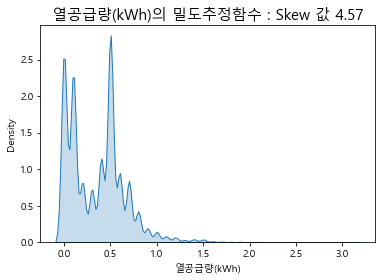

In [33]:
sns.kdeplot(org_data["열공급량(kWh)"], shade=True)
plt.title("열공급량(kWh)의 밀도추정함수 : Skew 값 4.57",fontsize=15)

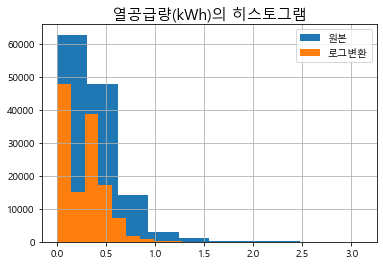

In [38]:
org_data["열공급량(kWh)"].hist(label="원본")
np.log1p(org_data["열공급량(kWh)"]).hist(label="로그변환")
plt.title("열공급량(kWh)의 히스토그램",fontsize=15)
plt.legend()

Text(0.5, 1.0, '천창의 밀도추정함수 : Skew 값 4.57')

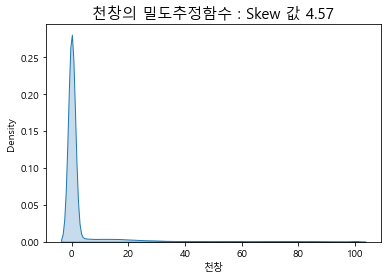

In [32]:
sns.kdeplot(org_data["천창"], shade=True)
plt.title("천창의 밀도추정함수 : Skew 값 4.57",fontsize=15)

Text(0.5, 1.0, '누적강수량의 밀도추정함수 : Skew 값 7.38')

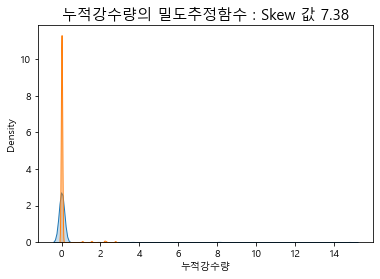

In [28]:
sns.kdeplot(org_data["누적강수량"], shade=True)
plt.title("누적강수량의 밀도추정함수 : Skew 값 7.38",fontsize=15)

Text(0.5, 1.0, '아황산가스_1시간의 밀도추정함수 : Skew 값 3.13')

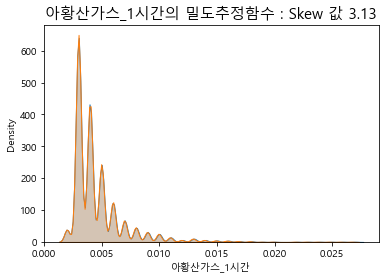

In [27]:
sns.kdeplot(org_data["아황산가스_1시간"], shade=True)
plt.title("아황산가스_1시간의 밀도추정함수 : Skew 값 3.13",fontsize=15)

In [39]:
# 왜도 3인 설명변수 log1p 변환
for val in ['일사량(W/㎡)','외기온(℃)','외기습도(%)','풍속(m/s)', '풍향(º)','내부 온도','내부 습도','차광스크린(수평)','차열스크린(수평)',
 '에너지스크린(수평)','에너지스크린(수직)','천창','난방온도(설정온도)','누적강수량','현지기압','해면기압','PM10_1시간','PM25_1시간',
 '오존_1시간','이산화질소_1시간','일산화탄소_1시간','아황산가스_1시간','지면온도']:
    if abs(data[val].skew()) > 2:
        print("log1p 변환이전 : ",abs(data[val].skew()))
        print(val)


log1p 변환이전 :  4.579098139125924
천창
log1p 변환이전 :  7.384725752483332
누적강수량
log1p 변환이전 :  3.13108520363669
아황산가스_1시간


log 변환해주기

In [30]:
np.log1p(org_data["천창"]).skew()

2.495661912698896

In [40]:
for val in ["천창","아황산가스_1시간"]:
    data[val] = np.log1p(data[val])

### 스케일링

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [42]:
data.head()

,시간,년도,월,시,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),누적강수량,현지기압,해면기압,일조,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,차광스크린_개방,차광스크린_개방조절,차열스크린_온도조절,차열스크린_개방조절,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전,하루길이,시간범주,일몰전후,일출일몰,지면온도,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급,이슬점,hour_float,cos_time,sin_time,일출시간_float,일몰시간_float,zenith,altitude,시간대별_평균열공급량,시간대별_열공급량표준편차
0,2021-11-26 00:00:00,2021,11,0,0.0,5.8,67,0.0,325,18.3,62.0,0,0,0,0,0,0.0,1,0.0,28,18.0,0.9,0.0,1018.2,1021.9,29180.0,33.0,22.0,0.003,0.028,0.4,0.002996,0,0,0,0,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,1,1,2,1,1,10.889913,0.000000,1.000000,0.000000,7.216667,17.283333,231.228926,-141.228926,0.473398,0.248416
1,2021-11-26 00:01:00,2021,11,0,0.0,5.8,67,0.4,344,18.1,63.4,0,0,0,0,0,0.0,1,0.0,28,18.0,0.9,0.0,1018.2,1021.9,0.0,33.0,22.0,0.003,0.028,0.4,0.002996,0,0,0,0,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,1,1,2,1,1,11.037352,0.016667,0.999990,0.004363,7.216667,17.283333,230.739259,-140.739259,0.473398,0.248416
2,2021-11-26 00:02:00,2021,11,0,0.0,5.7,67,0.9,105,17.7,65.2,0,0,0,0,0,0.0,1,1.0,28,18.0,0.9,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.002996,0,0,0,0,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,1,1,2,1,1,11.080268,0.033333,0.999962,0.008727,7.216667,17.283333,230.250259,-140.250259,0.473398,0.248416
3,2021-11-26 00:03:00,2021,11,0,0.0,5.7,67,1.3,123,17.7,63.9,0,0,0,0,0,0.0,1,1.0,28,18.0,0.8,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.002996,0,0,0,0,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,1,1,2,1,1,10.776831,0.050000,0.999914,0.013090,7.216667,17.283333,229.761926,-139.761926,0.473398,0.248416
4,2021-11-26 00:04:00,2021,11,0,0.0,5.7,67,0.9,123,17.6,64.7,0,0,0,0,0,0.0,1,1.0,28,18.0,1.0,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.002996,0,0,0,0,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,1,1,2,1,1,10.869295,0.066667,0.999848,0.017452,7.216667,17.283333,229.274259,-139.274259,0.473398,0.248416


MeanEncoding으로 모든 데이터가 numeric으로 변했으니 min,max?

In [43]:
train = data.iloc[:129448,:]
test = data.iloc[129448:,:]

In [44]:
for val in [x for x in data.columns if x not in ["열공급량(kWh)","시간","시간범주","일출일몰","일몰전후"]]:

    minmax = MinMaxScaler()
    
    train_data_scaled = minmax.fit_transform(train[val].values.reshape(-1,1))
    train[val] = train_data_scaled
    
    test_data_scaled = minmax.transform(test[val].values.reshape(-1,1))
    test[val] = test_data_scaled

In [45]:
data = pd.concat([train,test],axis=0)

------------------------------------------------------------------------------------------------------------------------------------

#### 1.1 데이터 처리하기
- 학습용 데이터 : ~2022.03
- 예측용 데이터 : 2022.03~

X 데이터 처리하기
- dummy 처리
- 왜도 처리

In [46]:
data_scaled = data.copy()

In [47]:
data_scaled.shape

(148168, 60)

In [48]:
# 년도 데이터를 numerical로 처리하기
Y = data_scaled["열공급량(kWh)"]

X_dummy = data_scaled.drop("열공급량(kWh)",axis=1)
X_dummy = X_dummy.drop(["시간"],axis=1)
X_dummy = pd.get_dummies(X_dummy,columns = ["일출일몰","일몰전후","시간범주"])

Y값 맨끝으로 위치시키기

#### 등급 데이터 제거하기

In [49]:
data_scaled_final = pd.concat([X_dummy, Y], axis = 1)

In [50]:
X_dummy.columns

Index(['년도', '월', '시', '일사량(W/㎡)', '외기온(℃)', '외기습도(%)', '풍속(m/s)', '풍향(º)',
       '내부 온도', '내부 습도', '차광스크린(수평)', '차열스크린(수평)', '에너지스크린(수평)', '에너지스크린(수직)',
       '배기팬', '천창', '유동팬', '팬코일 B동', '환기온도(천창 제어온도)', '난방온도(설정온도)', '누적강수량',
       '현지기압', '해면기압', '일조', 'PM10_1시간', 'PM25_1시간', '오존_1시간', '이산화질소_1시간',
       '일산화탄소_1시간', '아황산가스_1시간', '차광스크린_개방', '차광스크린_개방조절', '차열스크린_온도조절',
       '차열스크린_개방조절', '일출3시간후', '일출1시간후', '일몰3시간후', '일몰1시간반전', '하루길이', '지면온도',
       '오존등급', '아황산가스등급', '이산화질소등급', 'PM10등급', 'PM25등급', '이슬점', 'hour_float',
       'cos_time', 'sin_time', '일출시간_float', '일몰시간_float', 'zenith',
       'altitude', '시간대별_평균열공급량', '시간대별_열공급량표준편차', '일출일몰_일몰', '일출일몰_일출',
       '일몰전후_일몰1시간반_전', '일몰전후_일몰1시간반_후', '시간범주_그외', '시간범주_야간', '시간범주_주간'],
      dtype='object')

#### 범주 관련 변수들 다 제거해보기

In [51]:
data_scaled_final = data_scaled_final.drop(['오존등급', '아황산가스등급', '이산화질소등급', 'PM10등급', 'PM25등급',
                                           "해면기압","일출일몰_일출","일몰전후_일몰1시간반_전","일출일몰_일몰",
                                           "일몰전후_일몰1시간반_후","시간범주_그외","시간범주_야간",
                                           "시간범주_주간","일출3시간후","일출1시간후","일몰3시간후","일몰1시간반전","시",
                                           "해면기압","일조","altitude"],axis=1)

In [52]:
train_data = data_scaled_final.iloc[:129448,:]

test_data = data_scaled_final.iloc[129448:,:]

#### corr 확인하고 직접 변수 선택

In [56]:
#직접 corr 보고 제거하기
x_train = train_data.drop(["열공급량(kWh)","월","외기온(℃)","하루길이","cos_time","차광스크린_개방조절","차열스크린_개방조절"],axis=1)
y_train = train_data["열공급량(kWh)"]

x_test = test_data.drop(["열공급량(kWh)","월","외기온(℃)","하루길이","cos_time","차광스크린_개방조절","차열스크린_개방조절"],axis=1)
y_test = test_data["열공급량(kWh)"]

In [59]:
x_train.head(3)

,년도,일사량(W/㎡),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),누적강수량,현지기압,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,차광스크린_개방,차열스크린_온도조절,지면온도,이슬점,hour_float,sin_time,일출시간_float,일몰시간_float,zenith,시간대별_평균열공급량,시간대별_열공급량표준편차
0,0.0,0.0,0.643678,0.000000,0.901408,0.447257,0.485804,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.5,0.0,0.495017,0.311828,0.263889,0.028986,0.320513,0.142857,0.040477,0.0,0.0,0.280624,0.295370,0.000000,0.500000,0.368421,0.029851,0.934004,0.914205,0.332737
1,0.0,0.0,0.643678,0.024242,0.954930,0.438819,0.507886,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.5,0.0,0.495017,0.311828,0.263889,0.028986,0.320513,0.142857,0.040477,0.0,0.0,0.280624,0.303040,0.000695,0.502182,0.368421,0.029851,0.931566,0.914205,0.332737
2,0.0,0.0,0.643678,0.054545,0.281690,0.421941,0.536278,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,0.5,0.0,0.491694,0.311828,0.263889,0.028986,0.320513,0.142857,0.040477,0.0,0.0,0.280624,0.305273,0.001390,0.504363,0.368421,0.029851,0.929130,0.914205,0.332737


년월일 데이터 붙이기

#### target 데이터 log 변환 적용

In [57]:
data_transform = pd.concat([x_train,np.log1p(y_train)],axis=1)
data_transform.shape

(129448, 37)

In [58]:
data_transform.columns

Index(['년도', '일사량(W/㎡)', '외기습도(%)', '풍속(m/s)', '풍향(º)', '내부 온도', '내부 습도',
       '차광스크린(수평)', '차열스크린(수평)', '에너지스크린(수평)', '에너지스크린(수직)', '배기팬', '천창',
       '유동팬', '팬코일 B동', '환기온도(천창 제어온도)', '난방온도(설정온도)', '누적강수량', '현지기압',
       'PM10_1시간', 'PM25_1시간', '오존_1시간', '이산화질소_1시간', '일산화탄소_1시간', '아황산가스_1시간',
       '차광스크린_개방', '차열스크린_온도조절', '지면온도', '이슬점', 'hour_float', 'sin_time',
       '일출시간_float', '일몰시간_float', 'zenith', '시간대별_평균열공급량', '시간대별_열공급량표준편차',
       '열공급량(kWh)'],
      dtype='object')

In [59]:
# VIF 선택
reg_lunch = setup(
        data = data_transform,
        target='열공급량(kWh)',
        train_size = 0.8,
        session_id = 0,
        data_split_shuffle=True,
        fold_strategy = 'timeseries',
        #imputation_type='simple',
        normalize = False,
        #categorical_features = ["팬코일 B동","배기팬","유동팬","차광스크린_개방"],
        fold = 5,
        verbose= False,
        transform_target = False,
        silent= False, n_jobs= -1)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
년도,Categorical
일사량(W/㎡),Numeric
외기습도(%),Numeric
풍속(m/s),Numeric
풍향(º),Numeric
내부 온도,Numeric
내부 습도,Numeric
차광스크린(수평),Numeric
차열스크린(수평),Numeric
에너지스크린(수평),Numeric


In [60]:
best_5_d = compare_models(sort = 'RMSE', n_select = 5,round=4,cross_validation=True,verbose=True)
print(best_5_d)
## Altitude 안 빼기

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0725,0.0182,0.1347,0.6192,0.1010,0.3463,10.3820
et,Extra Trees Regressor,0.0722,0.0196,0.1398,0.5898,0.1047,0.3454,5.5320
lightgbm,Light Gradient Boosting Machine,0.0917,0.0199,0.1412,0.5821,0.1067,0.4142,0.5720
knn,K Neighbors Regressor,0.0876,0.0229,0.1513,0.5195,0.1143,0.4120,2.5260
gbr,Gradient Boosting Regressor,0.1110,0.0253,0.1590,0.4699,0.1209,0.4700,6.4040
dt,Decision Tree Regressor,0.0844,0.0316,0.1775,0.3382,0.1331,0.4067,0.3660
lr,Linear Regression,0.1307,0.0319,0.1786,0.3314,0.1363,0.5378,0.8820
ridge,Ridge Regression,0.1307,0.0319,0.1786,0.3315,0.1363,0.5374,0.6380
br,Bayesian Ridge,0.1306,0.0319,0.1786,0.3314,0.1363,0.5369,0.1960
lar,Least Angle Regression,0.1335,0.0328,0.1812,0.3119,0.1383,0.5520,0.1000


[RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False), ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=0, verbose=0, warm_start=False), LGBMRegressor(boosting_typ